# Spatio-temporal Transcriptomics

Toy dataset from López-Lopera et al. (2019)

- Data download: https://github.com/anfelopera/PhysicallyGPDrosophila

In [6]:
import numpy as np
import torch

from torch.nn import Parameter
from gpytorch.constraints import Interval
from matplotlib import pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
from os import path

from lafomo.utilities.torch import get_image
from lafomo.datasets import DrosophilaSpatialTranscriptomics
from lafomo.models import MultiOutputGP, PartialLFM
from lafomo.models.pdes import ReactionDiffusion
from lafomo.datasets import ToySpatialTranscriptomics, P53Data
from lafomo.configuration import VariationalConfiguration
from lafomo.plot import Plotter, plot_before_after
from lafomo.trainers import PDETrainer
from lafomo.utilities.torch import discretise
from lafomo.utilities.fenics import interval_mesh

In [7]:
def plot_spatiotemporal_data(images):
    """Data"""
    fig = plt.figure()
    grid = ImageGrid(fig, 111,  # similar to subplot(144)
                     nrows_ncols=(2, 3),
                     axes_pad=(0.45, 0.15),
                     label_mode="1",
                     share_all=True,
                     cbar_location="right",
                     cbar_mode="each",
                     cbar_size="7%",
                     cbar_pad="2%",
                     )

    for image, ax, cax in zip(images, grid, grid.cbar_axes):
        print(image.shape)
        im = ax.imshow(image, extent=[0, 1, 0, 1], origin='lower')#,  vmin=vlim[0], vmax=vlim[1])
        ax.axis('off')
        cb = plt.colorbar(im, cax=cax)
        cb.set_ticks(np.linspace(image.min(), int(image.max()/100)*100, 6))

    # This affects all axes because we set share_all = True.
    grid.axes_llc.set_xticks([-2, 0, 2])
    grid.axes_llc.set_yticks([-2, 0, 2])

In [8]:
kr_dataset = DrosophilaSpatialTranscriptomics(gene='kr', data_dir='../../../data')
kni_dataset = DrosophilaSpatialTranscriptomics(gene='kni', data_dir='../../../data')
gt_dataset = DrosophilaSpatialTranscriptomics(gene='gt', data_dir='../../../data')

drosophila = False

if drosophila:
    filepath = path.join('../../../experiments', 'dros-kr', 'partial', 'savedmodel')

    dataset = DrosophilaSpatialTranscriptomics(gene='kr', data_dir='../../../data')

    data = next(iter(dataset))
    tx, y_target = data
    lengthscale = 10
    images = [get_image(dataset.orig_data, i)
          for i in range(2, 4)
          for dataset in [kr_dataset, kni_dataset, gt_dataset]
          ]

    plot_spatiotemporal_data(images)
else:
    filepath = path.join('../../../experiments', 'toy-spatial', 'partial', 'savedmodel')

    dataset = ToySpatialTranscriptomics(data_dir='../../../data/')
    data = next(iter(dataset))
    tx, y_target = data
    lengthscale = 0.2

num_inducing = int(tx.shape[1] * 2/3)



We can either create a simple unit interval mesh

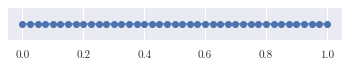

In [9]:
from dolfin import *

mesh = UnitIntervalMesh(40)
plot(mesh)

Alternatively, if our spatial data is not uniformly spaced, we can define a custom mesh as follows.

Matching: True
<class 'numpy.ndarray'>


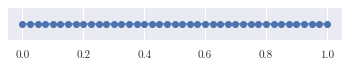

In [10]:
# We calculate a mesh that contains all possible spatial locations in the dataset

spatial = np.unique(tx[1, :])
mesh = interval_mesh(spatial)
plot(mesh)
# The mesh coordinates should match up to the data:
print('Matching:', all(spatial == mesh.coordinates().reshape(-1)))
#plot(mesh)
print(type(spatial))

Set up GP model

In [11]:
ts = tx[0, :].unique().sort()[0].numpy()
xs = tx[1, :].unique().sort()[0].numpy()
t_diff = ts[-1]-ts[0]
x_diff = xs[-1]-xs[0]
extent = [ts[0], ts[-1], xs[0], xs[-1]]
print(extent)

inducing_points = torch.stack([
    ts[0] + t_diff * torch.rand((1, num_inducing)),
    xs[0] + x_diff * torch.rand((1, num_inducing))
], dim=2)

gp_kwargs = dict(use_ard=True,
                 use_scale=False,
                 # lengthscale_constraint=Interval(0.1, 0.3),
                 learn_inducing_locations=False,
                 initial_lengthscale=lengthscale)
gp_model = MultiOutputGP(inducing_points, 1, **gp_kwargs)
gp_model.double();

[0.0, 1.0, 0.0, 1.0]


Set up PDE

In [12]:
t_range = (ts[0], ts[-1])
print(t_range)
time_steps = dataset.num_discretised
print(time_steps)

fenics_model = ReactionDiffusion(t_range, time_steps, mesh)

config = VariationalConfiguration(
    initial_conditions=False,
    num_samples=25
)

sensitivity = Parameter(torch.ones((1, 1), dtype=torch.float64), requires_grad=False)
decay = Parameter(0.1*torch.ones((1, 1), dtype=torch.float64), requires_grad=False)
diffusion = Parameter(0.01*torch.ones((1, 1), dtype=torch.float64), requires_grad=False)
fenics_params = [sensitivity, decay, diffusion]

lfm = PartialLFM(1, gp_model, fenics_model, fenics_params, config)

(0.0, 1.0)
40


In [16]:
train_mask = torch.zeros_like(tx[0,:])
train_mask[torch.randperm(tx.shape[1])[:int(0.3 * tx.shape[1])]] = 1
print(train_mask)
optimizer = torch.optim.Adam(lfm.parameters(), lr=0.07)
trainer = PDETrainer(lfm, optimizer, dataset,
                     track_parameters=list(lfm.fenics_named_parameters.keys()),
                     train_mask=train_mask)

tensor([0., 0., 0.,  ..., 0., 0., 0.], dtype=torch.float64)
t_sorted, dp [0.    0.025 0.05  0.075 0.1   0.125 0.15  0.175 0.2   0.225 0.25  0.275
 0.3   0.325 0.35  0.375 0.4   0.425 0.45  0.475 0.5   0.525 0.55  0.575
 0.6   0.625 0.65  0.675 0.7   0.725 0.75  0.775 0.8   0.825 0.85  0.875
 0.9   0.925 0.95  0.975 1.   ] 0.025
x dp is set to 0.025
t_sorted, dp [0.    0.025 0.05  0.075 0.1   0.125 0.15  0.175 0.2   0.225 0.25  0.275
 0.3   0.325 0.35  0.375 0.4   0.425 0.45  0.475 0.5   0.525 0.55  0.575
 0.6   0.625 0.65  0.675 0.7   0.725 0.75  0.775 0.8   0.825 0.85  0.875
 0.9   0.925 0.95  0.975 1.   ] 0.025


Now let's see some samples from the GP and corresponding LFM output

{'fenics0': Parameter containing:
tensor([[1.]], dtype=torch.float64, requires_grad=True), 'fenics1': Parameter containing:
tensor([[0.1000]], dtype=torch.float64, requires_grad=True), 'fenics2': Parameter containing:
tensor([[0.0100]], dtype=torch.float64, requires_grad=True), 'gp_model.variational_strategy.base_variational_strategy._variational_distribution.variational_mean': Parameter containing:
tensor([[ 7.1212e-01,  1.7010e+00,  1.6167e-01,  ..., -7.2279e-05,
          3.8400e-02, -8.0863e-03]], dtype=torch.float64, requires_grad=True), 'gp_model.variational_strategy.base_variational_strategy._variational_distribution.chol_variational_covar': Parameter containing:
tensor([[[ 1.7211e-01,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
           0.0000e+00,  0.0000e+00],
         [-2.2822e-01,  1.2097e-01,  0.0000e+00,  ...,  0.0000e+00,
           0.0000e+00,  0.0000e+00],
         [ 7.8316e-02, -2.9593e-02,  8.1646e-02,  ...,  0.0000e+00,
           0.0000e+00,  0.0000e+00],
      

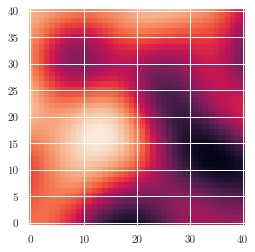

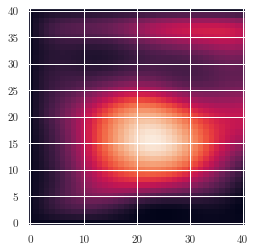

In [33]:
real = torch.tensor(dataset.orig_data[trainer.t_sorted, 2])
print(dict(lfm.named_parameters()))
plt.imshow(real.view(num_t, num_x).transpose(0, 1), origin='lower')
real = torch.tensor(dataset.orig_data[trainer.t_sorted, 3])
plt.figure()
plt.imshow(real.view(num_t, num_x).transpose(0, 1), origin='lower')

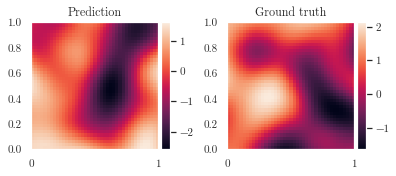

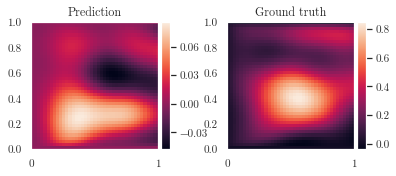

In [19]:
num_t = trainer.tx[0, :].unique().shape[0]
num_x = trainer.tx[1, :].unique().shape[0]

# gp_model.covar_module.lengthscale = 0.3*0.3 * 2
out = gp_model(tx.transpose(0, 1))

sample = out.sample(torch.Size([lfm.config.num_samples])).permute(0, 2, 1)
real = torch.tensor(dataset.orig_data[trainer.t_sorted, 2]).unsqueeze(0)


plot_before_after(
    sample[0].detach().view(num_t, num_x).transpose(0, 1),
    real.squeeze().view(num_t, num_x).transpose(0, 1),
    extent,
    titles=['Prediction', 'Ground truth']
)

sample = sample.view(lfm.config.num_samples, 1, num_t, num_x)
real = real.repeat(lfm.config.num_samples, 1, 1)
real = real.view(lfm.config.num_samples, 1, num_t, num_x)

out = lfm.solve_pde(sample)
real_out = lfm.solve_pde(real)

plot_before_after(
    out.mean(0).detach().transpose(0, 1),
    real_out[0].detach().transpose(0, 1),
    extent,
    titles=['Prediction', 'Ground truth']
)


tensor(0.1348, dtype=torch.float64, grad_fn=<MaxBackward1>) torch.Size([1681, 1]) torch.Size([1681, 1])
Epoch 011/020 - Loss: 1.02 (0.84 0.17) λ: [0.13744791 0.18041403] s: 1.0 dec: 0.1 diff: 0.01
tensor(0.1481, dtype=torch.float64, grad_fn=<MaxBackward1>) torch.Size([1681, 1]) torch.Size([1681, 1])
Epoch 012/020 - Loss: 0.94 (0.82 0.11) λ: [0.1327114  0.18419392] s: 1.0 dec: 0.1 diff: 0.01
tensor(0.1875, dtype=torch.float64, grad_fn=<MaxBackward1>) torch.Size([1681, 1]) torch.Size([1681, 1])
Epoch 013/020 - Loss: 0.87 (0.79 0.08) λ: [0.1269259  0.18851494] s: 1.0 dec: 0.1 diff: 0.01
tensor(0.2803, dtype=torch.float64, grad_fn=<MaxBackward1>) torch.Size([1681, 1]) torch.Size([1681, 1])
Epoch 014/020 - Loss: 0.86 (0.76 0.10) λ: [0.12066576 0.19487139] s: 1.0 dec: 0.1 diff: 0.01
tensor(0.2372, dtype=torch.float64, grad_fn=<MaxBackward1>) torch.Size([1681, 1]) torch.Size([1681, 1])
Epoch 015/020 - Loss: 0.85 (0.73 0.12) λ: [0.11647047 0.20206652] s: 1.0 dec: 0.1 diff: 0.01
tensor(0.1469, 

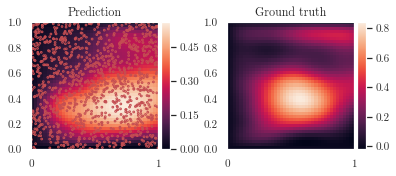

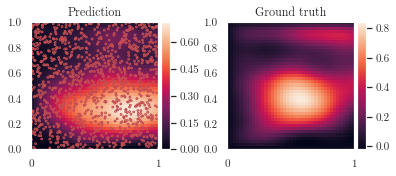

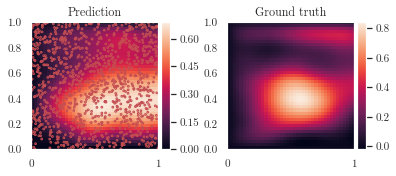

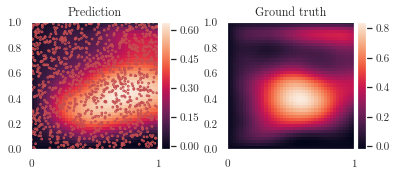

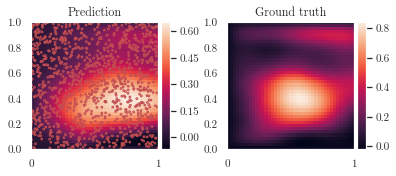

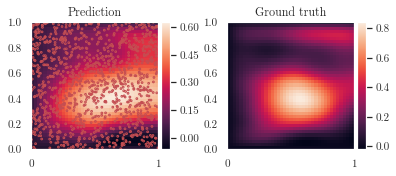

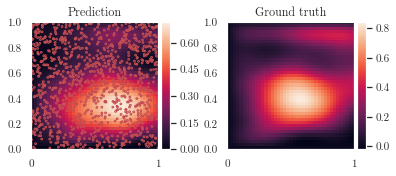

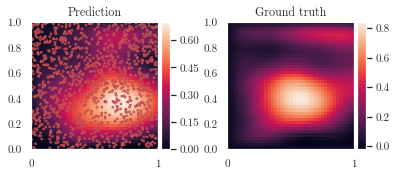

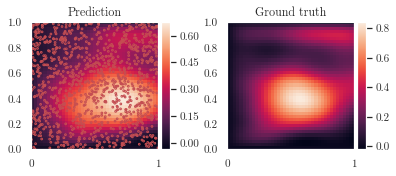

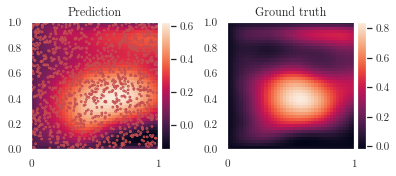

In [15]:
trainer.train(10)

In [45]:
# lfm.save(filepath)

In [11]:
lfm = PartialLFM.load(filepath,
                      gp_cls=MultiOutputGP,
                      gp_args=[inducing_points, 1],
                      gp_kwargs=gp_kwargs,
                      lfm_args=[1, fenics_model, fenics_params, config])
# lfm = PartialLFM(gp_model, fenics_model, fenics_params, config)

gp_model = lfm.gp_model
optimizer = torch.optim.Adam(lfm.parameters(), lr=0.07)
trainer = PDETrainer(lfm, optimizer, dataset, track_parameters=list(lfm.fenics_named_parameters.keys()))

t_sorted, dp [0.    0.025 0.05  0.075 0.1   0.125 0.15  0.175 0.2   0.225 0.25  0.275
 0.3   0.325 0.35  0.375 0.4   0.425 0.45  0.475 0.5   0.525 0.55  0.575
 0.6   0.625 0.65  0.675 0.7   0.725 0.75  0.775 0.8   0.825 0.85  0.875
 0.9   0.925 0.95  0.975 1.   ] 0.025
x dp is set to 0.025
t_sorted, dp [0.    0.025 0.05  0.075 0.1   0.125 0.15  0.175 0.2   0.225 0.25  0.275
 0.3   0.325 0.35  0.375 0.4   0.425 0.45  0.475 0.5   0.525 0.55  0.575
 0.6   0.625 0.65  0.675 0.7   0.725 0.75  0.775 0.8   0.825 0.85  0.875
 0.9   0.925 0.95  0.975 1.   ] 0.025


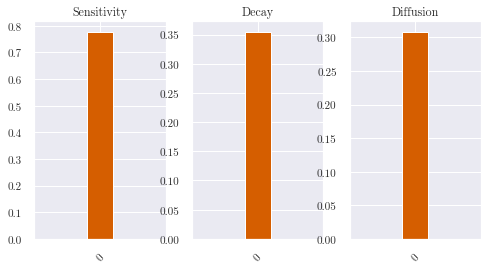

In [12]:
plotter = Plotter(lfm, np.arange(1))

labels = ['Sensitivity', 'Decay', 'Diffusion']
kinetics = list()
for key in lfm.fenics_named_parameters.keys():
    kinetics.append(trainer.parameter_trace[key][-1].squeeze().numpy())

plotter.plot_double_bar(kinetics, labels)

# plotter.plot_latents()